# 01 - Embeddings Preparation

Notebook scope:
- load dataset/config via shared helpers
- build vocabulary and analyse coverage (Q1a/Q1b)
- prepare OOV mitigation experiments (Q1c)
- stage embedding visualisation workflow (Q1d)

_Heavy lifting stays in `src/`; this notebook should read like a report._


## Imports & dataset setup

Establish a consistent configuration-driven pipeline. Keep raw outputs minimal so plots/tables remain easy to lift into the final report.


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

from src.config import load_data_config
from src.dataset_pipeline import prepare_tokenised_splits
from src.embeddings import load_torchtext_glove
from src.reports import build_vocabulary_report, compute_oov_report, top_tokens_by_label
from src.plotting import plot_barplot, plot_top_tokens_projection

data_config = load_data_config(Path("configs/data.yaml"))
splits = prepare_tokenised_splits(data_config)

len(splits.train), len(splits.validation), len(splits.test)


(4361, 1091, 500)

## Q1a - Vocabulary size

- Reuse `build_vocabulary_report` for corpus statistics.
- Persist intermediate artifacts (e.g., token frequencies) under `logs/` for reproducibility.


In [2]:
vocab_report = build_vocabulary_report(
    tokenised_dataset=splits.train,
    min_freq=data_config.vocabulary_min_freq,
    specials=data_config.vocabulary_specials,
)
vocab_report.summary()


{'documents': 4361,
 'total_tokens': 45591,
 'unique_tokens': 7477,
 'vocabulary_size': 7479,
 'min_frequency_threshold': 1}

In [3]:
import pandas as pd
from collections import Counter

label_counters = {
    split_name: Counter(label for label, _ in getattr(splits, split_name))
    for split_name in ['train', 'validation', 'test']
}
label_distribution_frame = (
    pd.DataFrame(label_counters)
    .fillna(0)
    .astype(int)
    .rename_axis('label')
    .sort_index()
    .reset_index()
)

label_distribution_frame.index.name = None
label_distribution_frame


,label,train,validation,test
0,ABBR,69,17,9
1,DESC,936,226,138
2,ENTY,1019,231,94
3,HUM,979,244,65
4,LOC,649,186,81
5,NUM,709,187,113


/Users/petterollinen/GitHub/NLP_Project_group45/src/plotting.py:320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


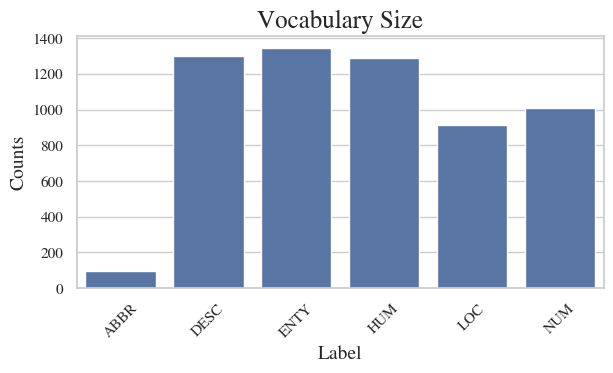

In [4]:
fig_vocab, ax_vocab = plot_barplot(
    x=label_distribution_frame['label'],
    y=label_distribution_frame[['train', 'validation', 'test']].sum(axis=1),
    title="Vocabulary Size",
)
plt.show()


## Q1b - OOV analysis

- Compare vocabulary against chosen embedding index via `compute_oov_report`.
- Produce per-class OOV counts using the helper's `per_label_summary()`.


In [5]:
vocab = vocab_report.vocabulary
embedding_result = load_torchtext_glove(
    vocabulary=vocab,
    name="6B",
    dim=100,
    trainable=True,
    random_seed=7,
)
oov_report = compute_oov_report(
    tokenised_dataset=splits.train,
    special_tokens=data_config.vocabulary_specials,
    embedding_result=embedding_result,
)
oov_report.summary()


{'unique_oov_words': 197,
 'oov_token_occurrences': 215,
 'mitigated_vectors': 199}

In [6]:
oov_report.per_label_summary()


[{'label': 'ABBR', 'unique_oov_words': 3, 'oov_token_occurrences': 4},
 {'label': 'DESC', 'unique_oov_words': 71, 'oov_token_occurrences': 72},
 {'label': 'ENTY', 'unique_oov_words': 53, 'oov_token_occurrences': 60},
 {'label': 'HUM', 'unique_oov_words': 42, 'oov_token_occurrences': 44},
 {'label': 'LOC', 'unique_oov_words': 14, 'oov_token_occurrences': 16},
 {'label': 'NUM', 'unique_oov_words': 18, 'oov_token_occurrences': 19}]

### OOV distribution
Tabular view before plotting for clarity.


In [7]:
import pandas as pd

per_label_df = pd.DataFrame(oov_report.per_label_summary())
per_label_df


,label,unique_oov_words,oov_token_occurrences
0,ABBR,3,4
1,DESC,71,72
2,ENTY,53,60
3,HUM,42,44
4,LOC,14,16
5,NUM,18,19


### OOV histogram
Visualising per-label OOV occurrences.


/Users/petterollinen/GitHub/NLP_Project_group45/src/plotting.py:320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


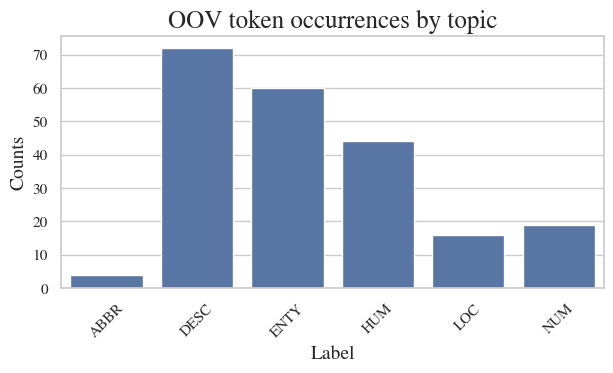

In [8]:
fig_oov, ax_oov = plot_barplot(
    x=per_label_df["label"].tolist(),
    y=per_label_df["oov_token_occurrences"].tolist(),
    title="OOV token occurrences by topic",
)
plt.show()


## Q1c - Mitigation strategy

- Compute the global mean of all in-vocabulary embeddings (excluding unknowns).
- Assign that mean vector to every OOV token before training.
- Keep the embeddings trainable.

### See 02_rnn for evalutation of the performance

In [9]:
from IPython.display import Markdown, display
mitigated_count = len(embedding_result.mitigated_tokens)
sample_tokens = list(embedding_result.mitigated_tokens.keys())[:10]
display(Markdown(f"Mitigated vectors generated for {mitigated_count} OOV tokens using the global mean. Example tokens: {', '.join(sample_tokens)}."))


Mitigated vectors generated for 199 OOV tokens using the global mean. Example tokens: -lantern, .., .dbf, 000th, 10-, 12601, 187s, 2th, 36893, 45mhz.

## Q1d - Embedding visualisation

- Use `plot_top_tokens_projection` to render scatter plots from the pre-computed token sets.
- Save figures under `plots/` for later inclusion in the report.


### Top tokens per topic
Preparing tokens for visualisation.


In [10]:
import seaborn as sns
from spacy.lang.en.stop_words import STOP_WORDS

top_tokens = top_tokens_by_label(
    tokenised_dataset=splits.train,
    top_k=20,
    stopwords=set(STOP_WORDS),
)
labels = sorted(top_tokens.keys())
label_palette = dict(zip(labels, sns.color_palette("tab10", n_colors=len(labels))))
legend_label_map = {label: label for label in labels}


### PCA projection
Legend placed below to reduce clutter.


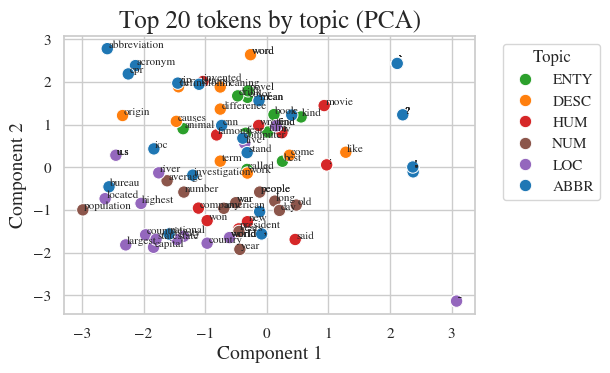

In [11]:
from src.plotting import plot_top_tokens_projection

projection_frame_pca, fig_pca, ax_pca = plot_top_tokens_projection(
    tokens_by_label=top_tokens,
    vocabulary=vocab_report.vocabulary,
    embedding_matrix=embedding_result.matrix,
    method="pca",
    title="Top 20 tokens by topic (PCA)",
    output_path=Path("plots/part1_top_tokens_pca.png"),
    annotate_tokens=True,
    legend_location="right",
    figure_fraction=1,
    label_palette=label_palette,
    legend_label_map=legend_label_map,
    point_size=80,
)


### t-SNE projection
Lower-dimensional view via t-SNE (perplexity 15).


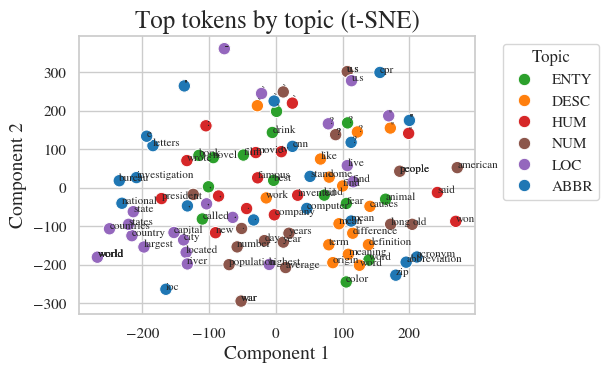

In [12]:
from src.plotting import plot_top_tokens_projection

projection_frame_tsne, fig_tsne, ax_tsne = plot_top_tokens_projection(
    tokens_by_label=top_tokens,
    vocabulary=vocab_report.vocabulary,
    embedding_matrix=embedding_result.matrix,
    method="tsne",
    title="Top tokens by topic (t-SNE)",
    output_path=Path("plots/part1_top_tokens_tsne.png"),
    annotate_tokens=True,
    legend_location="right",
    tsne_perplexity=15.0,
    figure_fraction=1,
    label_palette=label_palette,
    legend_label_map=legend_label_map,
    point_size=80,
)
